In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyinterp.backends.xarray  # Module that handles the filling of undefined values.
import pyinterp.fill
import seaborn as sns
import xarray as xr
from matplotlib.patches import Rectangle

In [2]:
auth = earthaccess.login("../login.netrc")

In [ ]:
tspan = ('2024-09-24','2024-10-10')
results = earthaccess.search_datasets(instrument="spexone")
for item in results:
    summary = item.summary()
"""
"TAU_MODE1_550nm": "TAU_OBS_MODE_FINE_550nm",
"TAU_MODE2_550nm": "TAU_OBS_MODE_CI_550nm",
"TAU_MODE3_550nm": "TAU_OBS_MODE_CS_550nm",
"""  
results = earthaccess.search_data(
    short_name="PACE_SPEXONE_L2_AER_RTAPOCEAN",
    temporal = tspan,
    # lon, lon, lat, lat wsen
    bounding_box = (-33.4435, 13.3830,  -10.4448, 29.5381) #WSEN
)

for i, granule in enumerate(results, 1):
    file_name = granule["umm"]["GranuleUR"]
    data_links = granule.data_links(access="https")  # HTTPS for laptop
    # Use access="direct" in CryoCloud (us-west-2)
    file_url = data_links[0] if data_links else "No URL available"
    print(f"{i}. FileName: {file_name}")
    # print(f"   URL: {file_url}")

1. FileName: PACE_SPEXONE_L2_AER_RTAPOCEAN_PACE_SPEXONE.20240901T141329.L2.RTAP_OC.V3_0.nc_3.0
2. FileName: PACE_SPEXONE_L2_AER_RTAPOCEAN_PACE_SPEXONE.20240901T141829.L2.RTAP_OC.V3_0.nc_3.0
3. FileName: PACE_SPEXONE_L2_AER_RTAPOCEAN_PACE_SPEXONE.20240902T144756.L2.RTAP_OC.V3_0.nc_3.0
4. FileName: PACE_SPEXONE_L2_AER_RTAPOCEAN_PACE_SPEXONE.20240902T145256.L2.RTAP_OC.V3_0.nc_3.0
5. FileName: PACE_SPEXONE_L2_AER_RTAPOCEAN_PACE_SPEXONE.20240903T134402.L2.RTAP_OC.V3_0.nc_3.0
6. FileName: PACE_SPEXONE_L2_AER_RTAPOCEAN_PACE_SPEXONE.20240903T134902.L2.RTAP_OC.V3_0.nc_3.0
7. FileName: PACE_SPEXONE_L2_AER_RTAPOCEAN_PACE_SPEXONE.20240904T141825.L2.RTAP_OC.V3_0.nc_3.0
8. FileName: PACE_SPEXONE_L2_AER_RTAPOCEAN_PACE_SPEXONE.20240904T142325.L2.RTAP_OC.V3_0.nc_3.0
9. FileName: PACE_SPEXONE_L2_AER_RTAPOCEAN_PACE_SPEXONE.20240905T131931.L2.RTAP_OC.V3_0.nc_3.0
10. FileName: PACE_SPEXONE_L2_AER_RTAPOCEAN_PACE_SPEXONE.20240905T145248.L2.RTAP_OC.V3_0.nc_3.0
11. FileName: PACE_SPEXONE_L2_AER_RTAPOCEAN_PACE_

QUEUEING TASKS | :   0%|          | 0/100 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/100 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/100 [00:00<?, ?it/s]

Streamed files (auto-detected provider):
ob-cumulus-prod-public/PACE_SPEXONE.20240901T141329.L2.RTAP_OC.V3_0.nc
ob-cumulus-prod-public/PACE_SPEXONE.20240901T141829.L2.RTAP_OC.V3_0.nc
ob-cumulus-prod-public/PACE_SPEXONE.20240902T144756.L2.RTAP_OC.V3_0.nc
ob-cumulus-prod-public/PACE_SPEXONE.20240902T145256.L2.RTAP_OC.V3_0.nc
ob-cumulus-prod-public/PACE_SPEXONE.20240903T134402.L2.RTAP_OC.V3_0.nc
ob-cumulus-prod-public/PACE_SPEXONE.20240903T134902.L2.RTAP_OC.V3_0.nc
ob-cumulus-prod-public/PACE_SPEXONE.20240904T141825.L2.RTAP_OC.V3_0.nc
ob-cumulus-prod-public/PACE_SPEXONE.20240904T142325.L2.RTAP_OC.V3_0.nc
ob-cumulus-prod-public/PACE_SPEXONE.20240905T131931.L2.RTAP_OC.V3_0.nc
ob-cumulus-prod-public/PACE_SPEXONE.20240905T145248.L2.RTAP_OC.V3_0.nc
ob-cumulus-prod-public/PACE_SPEXONE.20240905T145748.L2.RTAP_OC.V3_0.nc
ob-cumulus-prod-public/PACE_SPEXONE.20240906T134854.L2.RTAP_OC.V3_0.nc
ob-cumulus-prod-public/PACE_SPEXONE.20240906T135354.L2.RTAP_OC.V3_0.nc
ob-cumulus-prod-public/PACE_SPEXONE.

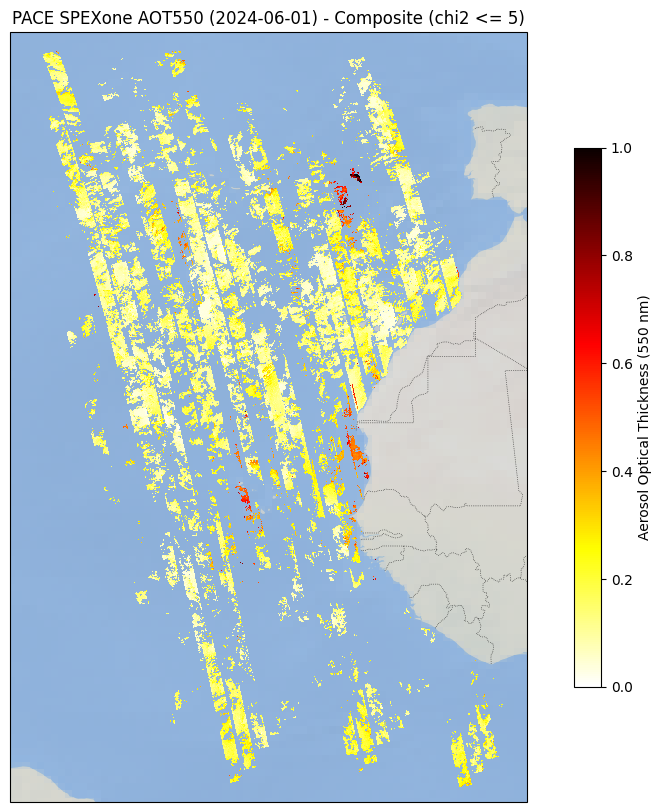

In [13]:
import earthaccess
import h5py
import numpy as np
import pandas as pd
import matplotlib
# Set the backend to 'Agg' for non-interactive plotting, which is more reliable for scripts.
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ssl
import os
# --- Stream without specifying provider (optional, for comparison) ---
files_auto = earthaccess.open(results)  # Auto-detects provider
print("Streamed files (auto-detected provider):")#, [f.path for f in files_auto])
for f in files_auto:
    print(f.path)
    
# --- Common Providers: --
# POCLOUD: Oceanography (e.g., PACE, SWOT).
# GESDISC: Atmospheric data (e.g., OMI, TROPOMI).
# NSIDCDAAC: Cryospheric data (e.g., ICESat-2).
# LPDAAC: Land data (e.g., MODIS, VIIRS).
# ASDC: Atmospheric science (e.g., CALIPSO).


# --- Data Aggregation for furthe analysis ---
all_lons = []
all_lats = []
all_aots_masked = []
print("\n--- Aggregating data from all files ---")
for f in files_auto:
    print(f"Processing: {os.path.basename(f.path)}")
    try:
        with h5py.File(f, mode="r") as ds_h5py:
            if 'geophysical_data' in ds_h5py and 'aot550' in ds_h5py['geophysical_data']:
                aot550 = ds_h5py['geophysical_data']['aot550'][:]
                lat = ds_h5py['geolocation_data']['latitude'][:]
                lon = ds_h5py['geolocation_data']['longitude'][:]
                chi2 = ds_h5py['diagnostic_data']['chi2'][:]
                fill_value = ds_h5py['geophysical_data']['aot550'].attrs['_FillValue']

                # Add chi2 filter to the mask
                # over land chi2 5
                # over ocean chi2 10
                aot550_masked = np.ma.masked_where(
                    (aot550 == fill_value) | (aot550 < 0) | (aot550 > 5) | np.isnan(aot550) | (chi2 > 10),
                    aot550
                )
                if aot550_masked.count() > 0:
                    all_lons.append(lon)
                    all_lats.append(lat)
                    all_aots_masked.append(aot550_masked)
            else:
                print(f"--> Skipping: 'aot550' or 'geophysical_data' not found.")
    except Exception as e:
        print(f"--> Error reading file {os.path.basename(f.path)}: {e}")

# --- Plotting aod map---
if all_lons:
    print("\n--- Creating composite plot ---")
    fig = plt.figure(figsize=(12, 10))
    # Revert to PlateCarree to allow for a regional extent
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Dynamically set the extent to fit all plotted data
    min_lon = np.min([np.min(l) for l in all_lons])
    max_lon = np.max([np.max(l) for l in all_lons])
    min_lat = np.min([np.min(l) for l in all_lats])
    max_lat = np.max([np.max(l) for l in all_lats])
    ax.set_extent([min_lon - 1, max_lon + 1, min_lat - 1, max_lat + 1], crs=ccrs.PlateCarree())

    # Use stock image for a realistic background
    ax.stock_img()
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0, alpha=0.8)
    ax.add_feature(cfeature.OCEAN, zorder=0, alpha=0.8)
    # ax.add_feature(cfeature.COASTLINE, zorder=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, alpha=0.8)
    # ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    mesh = None
    for lon, lat, aot in zip(all_lons, all_lats, all_aots_masked):
        # Use reversed 'hot' colormap
        mesh = ax.pcolormesh(
            lon, lat, aot, cmap='hot_r',
            vmin=0, vmax=1.0, transform=ccrs.PlateCarree(), zorder=2
        )

    plt.colorbar(mesh, label='Aerosol Optical Thickness (550 nm)', ax=ax, shrink=0.7)
    plt.title('PACE SPEXone AOT550 (2024-06-01) - Composite (chi2 <= 5)')

    output_path = "./aot550_map_composite.png"
    #os.makedirs(os.path.dirname(output_path), exist_ok=True)
    # Save with a standard white background
    #plt.savefig(output_path, dpi=300, bbox_inches='tight')
    #print(f"Composite plot saved to: {output_path}")
    #plt.close(fig)
    %matplotlib inline
    
    plt.show()
else:
    print("\nNo valid data found in any file to plot.")

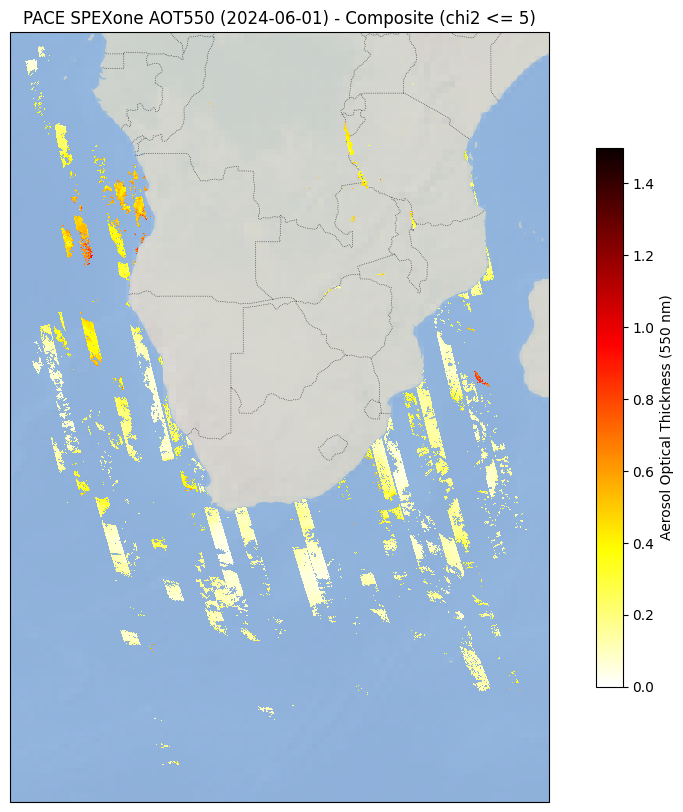

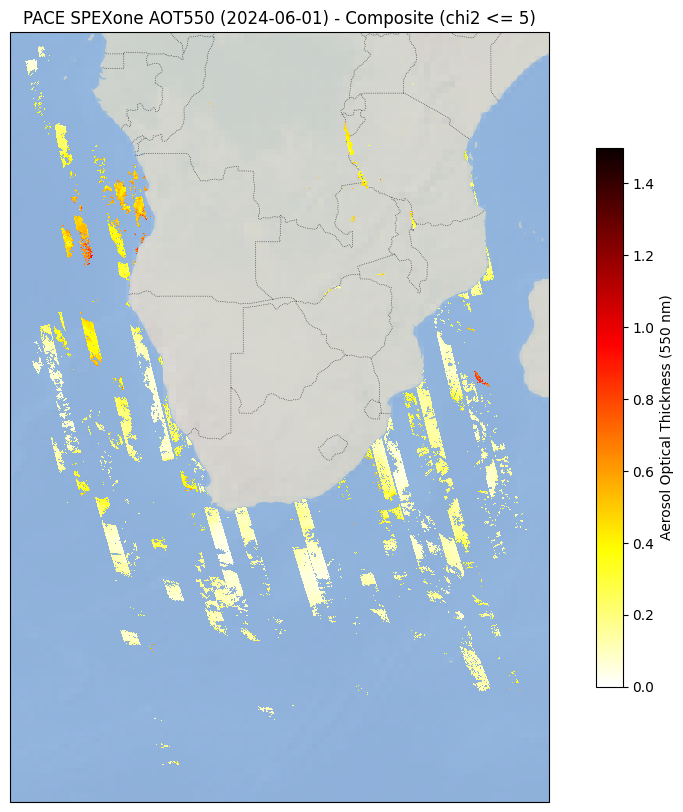

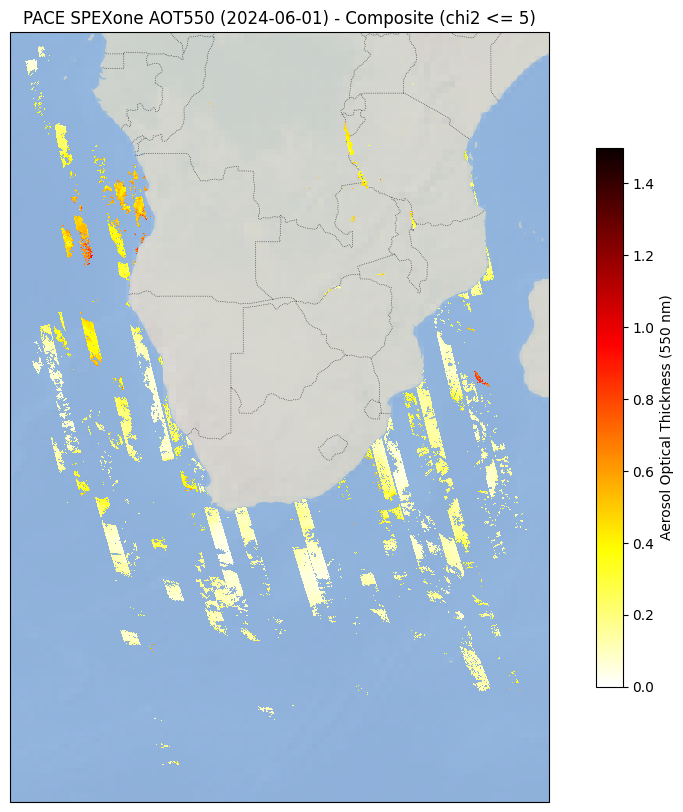

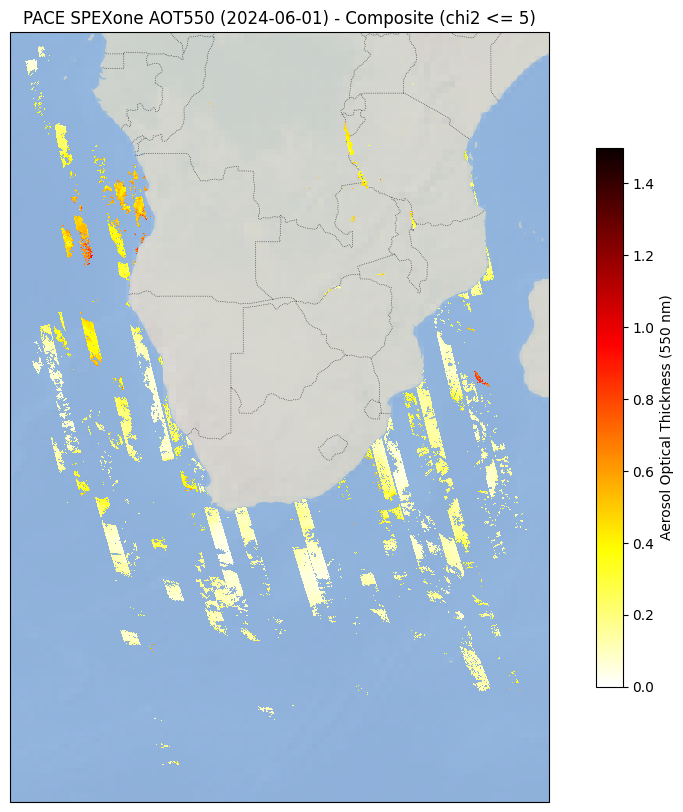

In [ ]:

plt.plot([1,2,3])
plt.show()